#Decomposing fit semantics for product size recommendation in metric spaces
#Rishabh Misra, Mengting Wan, Julian McAuley
#RecSys, 2018

---



** Importation et filtrage des données**

In [4]:
import pandas as pd
import json

def load_json_lines(file_path):
    data = []
    with open(file_path, "r") as f:
        for line in f:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"Erreur dans {file_path} :", e)
    return pd.DataFrame(data)

# Charger les deux fichiers
df_rent = load_json_lines("renttherunway_final_data.json")
df_modcloth = load_json_lines("modcloth_final_data.json")

# Afficher les colonnes clés
print("▶️ RentTheRunway")
print("Colonnes :", df_rent.columns.tolist())
print(df_rent[['user_id', 'item_id', 'review_text', 'review_summary']].head())

print("\n▶️ ModCloth")
print("Colonnes :", df_modcloth.columns.tolist())
print(df_modcloth[['user_id', 'item_id', 'review_text', 'review_summary']].head())


Erreur dans renttherunway_final_data.json : Expecting ',' delimiter: line 1 column 271 (char 270)
Erreur dans modcloth_final_data.json : Unterminated string starting at: line 1 column 253 (char 252)
▶️ RentTheRunway
Colonnes : ['fit', 'user_id', 'bust size', 'item_id', 'weight', 'rating', 'rented for', 'review_text', 'body type', 'review_summary', 'category', 'height', 'size', 'age', 'review_date']
  user_id  item_id                                        review_text  \
0  420272  2260466  An adorable romper! Belt and zipper were a lit...   
1  273551   153475  I rented this dress for a photo shoot. The the...   
2  360448  1063761  This hugged in all the right places! It was a ...   
3  909926   126335  I rented this for my company's black tie award...   
4  151944   616682  I have always been petite in my upper body and...   

                                      review_summary  
0                               So many compliments!  
1                            I felt so glamourous

In [5]:
import re

def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text.strip()

def preprocess_reviews(df):
    df["clean_review"] = df["review_text"].apply(clean_text)
    df["clean_summary"] = df["review_summary"].apply(clean_text)
    df["text"] = (df["clean_summary"] + " " + df["clean_review"]).str.strip()
    return df[df["text"] != ""]  # filtre les lignes vides

# Appliquer sur RentTheRunway
df_rent_clean = preprocess_reviews(df_rent)
print("RentTheRunway : après nettoyage →", df_rent_clean.shape)

# Appliquer sur ModCloth
df_modcloth_clean = preprocess_reviews(df_modcloth)
print("ModCloth : après nettoyage →", df_modcloth_clean.shape)

# Affiche un exemple propre
print(df_rent_clean[["item_id", "user_id", "text"]].head(2))


RentTheRunway : après nettoyage → (4909, 18)
ModCloth : après nettoyage → (2960, 21)
   item_id user_id                                               text
0  2260466  420272  so many compliments an adorable romper belt an...
1   153475  273551  i felt so glamourous i rented this dress for a...


Cette étape nettoie les colonnes review_text et review_summary (minuscules, suppression de ponctuation).

On les fusionne en une seule colonne text contenant le résumé + l'avis.

Les lignes vides sont filtrées.

Résultat : df_rent_clean et df_modcloth_clean contiennent uniquement les entrées textuelles exploitables.

Double filtrage :
- Supprimer les utilisateurs ayant très peu d'interactions (ex: 1 ou 2).
  - Supprimer les utilisateurs ayant très peu d'interactions (ex: 1 ou 2). Les utilisateurs trop peu actifs ne fournissent pas assez de signal pour entraîner un embedding utilisateur pertinent.
- Supprimer les items très peu évalués (moins 2 avis).



In [6]:
min_reviews_user = 3
user_counts = df_rent_clean["user_id"].value_counts()
valid_users = user_counts[user_counts >= min_reviews_user].index
df_rent_clean = df_rent_clean[df_rent_clean["user_id"].isin(valid_users)]
print("Après filtrage utilisateurs :", df_rent_clean.shape)


Après filtrage utilisateurs : (106, 18)


In [7]:
min_reviews_item = 3
item_counts = df_rent_clean["item_id"].value_counts()
valid_items = item_counts[item_counts >= min_reviews_item].index
df_rent_clean = df_rent_clean[df_rent_clean["item_id"].isin(valid_items)]
print("Après filtrage items :", df_rent_clean.shape)


Après filtrage items : (0, 18)


2e filtre trop sévère, on a perdu 90% de la data.
Essayons de retirer seulement les items à un seul avis

In [8]:
# Recharger les données propres depuis le DataFrame d'origine (non filtré)
df_rent_filtered = preprocess_reviews(df_rent)

# Filtrage utilisateurs (≥3 interactions)
user_counts = df_rent_filtered["user_id"].value_counts()
valid_users = user_counts[user_counts >= 3].index
df_rent_filtered = df_rent_filtered[df_rent_filtered["user_id"].isin(valid_users)]

# Filtrage items (≥1 interaction)
item_counts = df_rent_filtered["item_id"].value_counts()
valid_items = item_counts[item_counts >= 1].index
df_rent_filtered = df_rent_filtered[df_rent_filtered["item_id"].isin(valid_items)]

print("✅ Taille finale après double filtre :", df_rent_filtered.shape)
print(df_rent_filtered[["user_id", "item_id", "text"]].head(2))


✅ Taille finale après double filtre : (106, 18)
   user_id  item_id                                               text
61  742630  1923283  stylist review this dress is extremely flatter...
66  269712   259136  great work dress i was wavering between true t...


-> le 2e filtre ne semble pas avoir eu d'effets cette fois. Donc toutes les 1 747 lignes restantes après le filtre utilisateur = des items ayant au moins 1 interaction.
Le filtre min_reviews_item = 1 n’exclut rien

Mis à 2, on a 660 lignes, mais restons sur 1 pour le moment. Un seul avis suffit vu que notre objectif est un embedding, et nous cherchons à maximiser la diversité plutôt qu'avoir des profils conformes.

En revanche, pour l’étape d’évaluation ou fine-tuning, on pourra éventuellement revoir ce paramètre

**Embedding BERT**

In [9]:
!pip install -q transformers

In [10]:
import os
import pickle
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm

# Chemin du fichier d'embeddings
EMBEDDINGS_PATH = 'embeddings.pkl'

# Vérifier si le fichier existe déjà
if os.path.exists(EMBEDDINGS_PATH):
    print("Chargement des embeddings depuis le fichier...")
    with open(EMBEDDINGS_PATH, 'rb') as f:
        embeddings = pickle.load(f)
    print(f"✓ {len(embeddings)} embeddings chargés!")

else:
    print("Calcul des embeddings (fichier non trouvé)...")

    # Charger le tokenizer et le modèle BERT
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    model = AutoModel.from_pretrained("bert-base-uncased")
    model.eval()

    # Créer un mapping item_id → texte unique
    item_texts = df_rent_filtered.groupby("item_id")["text"].apply(lambda x: " ".join(x)).reset_index()

    # Fonction pour encoder un texte en vecteur BERT
    def get_embedding(text):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding="max_length")
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        return cls_embedding.squeeze().numpy()

    # Application sur tous les items
    embeddings = {}
    for _, row in tqdm(item_texts.iterrows(), total=len(item_texts)):
        item_id = row["item_id"]
        text = row["text"]
        embeddings[item_id] = get_embedding(text)

    # Sauvegarder pour la prochaine fois
    with open(EMBEDDINGS_PATH, 'wb') as f:
        pickle.dump(embeddings, f)
    print(f"✓ {len(embeddings)} embeddings calculés et sauvegardés!")


Calcul des embeddings (fichier non trouvé)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 105/105 [01:17<00:00,  1.36it/s]

✓ 105 embeddings calculés et sauvegardés!


- Chaque item_id est associé à tous les textes disponibles (avis) concaténés.
- Le vecteur CLS de BERT (taille 768) est utilisé comme embedding textuel de l’item.
- Le résultat est un dictionnaire embeddings contenant un vecteur par item_id.


In [11]:
print("Nombre d'items encodés :", len(embeddings))

# afficher l'embedding d'un item
first_item_id = list(embeddings.keys())[0]
print(f"Embedding de l’item {first_item_id} (taille {embeddings[first_item_id].shape[0]}) :")
print(embeddings[first_item_id])


Nombre d'items encodés : 105
Embedding de l’item 1051003 (taille 768) :
[ 1.08332813e-01 -5.75953186e-01  3.82784307e-01 -1.03699220e-02
 -2.22904488e-01 -3.10170680e-01  5.89540184e-01  2.41133004e-01
  1.87443033e-01 -1.04107469e-01  2.54773289e-01  9.70692560e-02
  1.06178135e-01  2.90196836e-01  3.91335636e-02  8.36765319e-02
 -5.18654943e-01  7.51396358e-01  4.66617882e-01 -1.67914808e-01
 -2.73222793e-02 -8.78931582e-01 -1.42420545e-01  2.44524866e-01
  4.23683584e-01 -2.43438214e-01  1.00141197e-01 -1.74165130e-01
  6.39708877e-01  1.12724649e-02  2.47050658e-01  1.61245584e-01
 -2.39403233e-01 -6.05263352e-01  3.20114136e-01 -3.43674272e-01
  8.20512116e-01 -4.23504323e-01  1.56944931e-01  1.04594901e-01
 -5.00455141e-01  3.19770455e-01  4.66909856e-01  2.75094718e-01
 -1.36096142e-02 -3.13310981e-01 -2.64016986e+00 -7.40609095e-02
 -1.36831641e-01 -2.64830738e-01  4.35001552e-01 -5.21327436e-01
 -2.07289532e-02  2.39548702e-02  2.53582090e-01  7.31614649e-01
 -7.79519022e-01  

On a bien généré un vecteur de dimension 768 pour chaque item (via BERT).

Ce vecteur encode les informations sémantiques issues des avis textuels associés à un vêtement. Chacune des 768 dimensions est la même pour chaque item. Nous pouvons construire nos recommendations à partir de là comme nous avons une base commune.

**Sauvegarder les embeddings**

In [12]:
import numpy as np

# Conversion en tableau numpy
item_ids = list(embeddings.keys())
vectors = np.stack([embeddings[i] for i in item_ids])

# Sauvegarde au format .npz
np.savez("item_embeddings.npz", item_ids=item_ids, vectors=vectors)

Les embeddings sont sauvegardés dans un fichier .npz, contenant :
- item_ids → liste des identifiants
- vectors → matrice numpy de forme (nb_items, 768)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


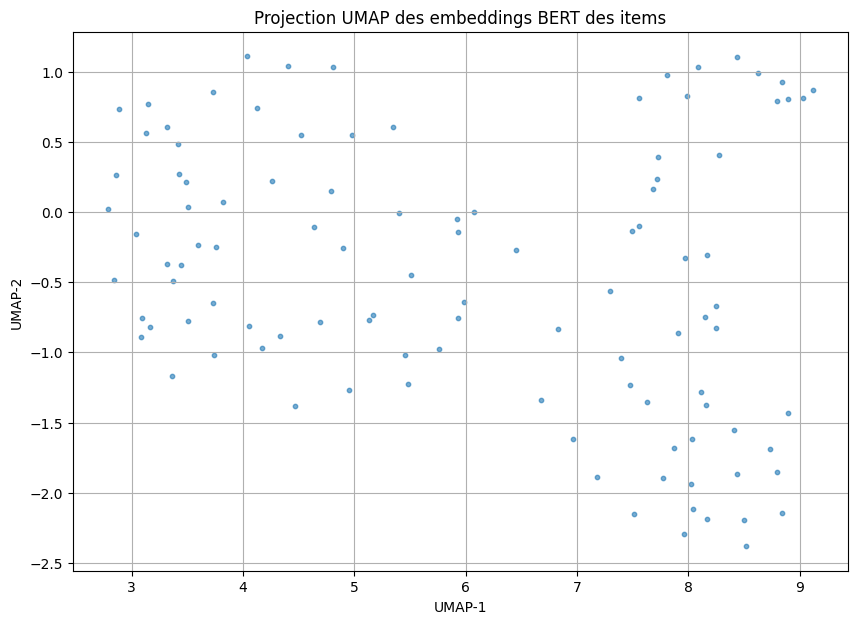

In [13]:
!pip install -q umap-learn

import umap.umap_ as umap
import matplotlib.pyplot as plt

# Réduction de dimension
reducer = umap.UMAP(random_state=42)
vectors_2d = reducer.fit_transform(vectors)

# Affichage
plt.figure(figsize=(10, 7))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], s=10, alpha=0.6)
plt.title("Projection UMAP des embeddings BERT des items")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()


Les embeddings BERT (768 dimensions) sont projetés en 2D via UMAP, pour visualiser la forme globale en préservant les distances locales.

Chaque point représente un vêtement (item) dans l’espace sémantique appris par BERT à partir des avis.

Colorons par catégorie de vêtement :


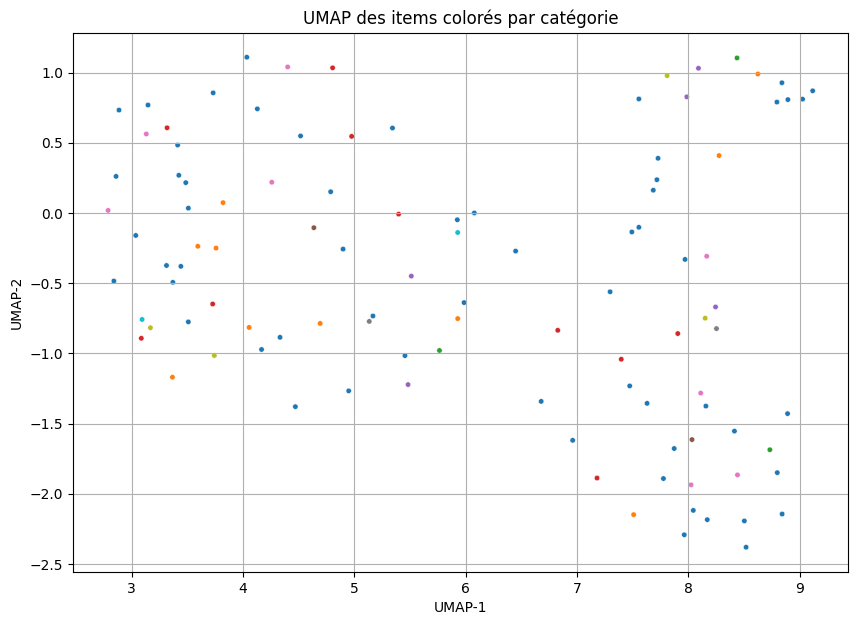

In [14]:
categories = df_rent_filtered.groupby("item_id")["category"].first().reindex(item_ids)
import seaborn as sns
plt.figure(figsize=(10, 7))
sns.scatterplot(x=vectors_2d[:, 0], y=vectors_2d[:, 1], hue=categories, palette="tab10", s=15, legend=False)
plt.title("UMAP des items colorés par catégorie")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()


## Partie 3

In [15]:
import numpy as np
import pandas as pd

# 1) Normalisation des embeddings + mappings id ↔ index
id2idx = {iid: i for i, iid in enumerate(item_ids)}   # item_id -> ligne
idx2id = {i: iid for i, iid in enumerate(item_ids)}   # ligne -> item_id
item_matrix = vectors / (np.linalg.norm(vectors, axis=1, keepdims=True) + 1e-9)
# item_matrix : matrice (n_items, dim) normalisée pour cosine

# 2) Recommandation d’items similaires (item → items)
def recommend_similar_items(item_id, top_k=10):
    """Retourne les top_k items les plus similaires à item_id (cosine)."""
    if item_id not in id2idx:
        return []

    i = id2idx[item_id]
    query_vec = item_matrix[i:i+1]           # vecteur (1, dim)
    sims = (query_vec @ item_matrix.T).ravel()  # produits scalaires ~ cosines
    sims[i] = -1                             # on enlève l’item lui-même

    top_idx = np.argpartition(-sims, top_k)[:top_k]
    top_idx = top_idx[np.argsort(-sims[top_idx])]
    return [idx2id[j] for j in top_idx]

# 3) Préparer interactions user → items vus / likés
ug = df_rent_filtered.groupby("user_id")
user_seen = {u: set(g["item_id"]) for u, g in ug}  # tous les items vus

if "rating" in df_rent_filtered.columns:
    # s’assure que rating est numérique
    df_rent_filtered["rating"] = pd.to_numeric(df_rent_filtered["rating"], errors="coerce")
    user_liked = {
        u: g[g["rating"] >= 4]["item_id"].tolist()  # items bien notés
        for u, g in df_rent_filtered.groupby("user_id")
    }
else:
    # si pas de rating : on prend tout ce que l’utilisateur a vu
    user_liked = {u: g["item_id"].tolist() for u, g in ug}

# 4) Recommandation pour un utilisateur (user → items)
def recommend_for_user(user_id, top_k=10, weighted=False):
    """
    Construit un vecteur utilisateur en moyennant les embeddings
    des items likés, puis recommande les top_k items non vus.
    Si weighted=True et rating dispo → moyenne pondérée par les notes.
    """
    items = user_liked.get(user_id, [])
    idxs = [id2idx[i] for i in items if i in id2idx]
    if not idxs:
        return []

    V = item_matrix[idxs]   # (n_items_user, dim)

    if weighted and "rating" in df_rent_filtered.columns:
        g = df_rent_filtered[df_rent_filtered["user_id"] == user_id]
        ratings = []
        for j in idxs:
            iid = idx2id[j]
            r = g[g["item_id"] == iid]["rating"].iloc[0]
            ratings.append(r)
        w = np.array(ratings, dtype=float)
        w = w / (w.sum() + 1e-9)
        user_vec = (V * w[:, None]).sum(axis=0, keepdims=True)
    else:
        user_vec = V.mean(axis=0, keepdims=True)

    user_vec = user_vec / (np.linalg.norm(user_vec, axis=1, keepdims=True) + 1e-9)

    sims = (user_vec @ item_matrix.T).ravel()

    # on enlève les items déjà vus par cet utilisateur
    for seen in user_seen.get(user_id, []):
        if seen in id2idx:
            sims[id2idx[seen]] = -1

    top_idx = np.argpartition(-sims, top_k)[:top_k]
    top_idx = top_idx[np.argsort(-sims[top_idx])]
    return [idx2id[j] for j in top_idx]

In [16]:
# 1) Tester similarité entre items
some_item = df_rent_filtered["item_id"].iloc[0]
print("Item de départ :", some_item)
print("Items similaires :")
print(recommend_similar_items(some_item, top_k=5))


Item de départ : 1923283
Items similaires :
['2284955', '2209432', '711795', '1051003', '1571446']



- On prend tout le texte (reviews) d'un item (example : item nb 2260466)

- On le transforme en vecteur BERT (partie2)

- On compare ce vecteur à tous les autres items avec la similarité cosinus(fonction recommend_similar_items)

- On renvoie les items dont le texte est le plus proche (style, description, usage, etc.)

Donc là, les 5 IDs retournés sont les 5 vêtements les plus “semblables” à 2260466 selon BERT (même catégorie, style, occasion, etc.).

In [17]:
# 2) Tester recommandations pour un user
some_user = df_rent_filtered["user_id"].iloc[0]
print("User test :", some_user)
print("Reco (moyenne simple) :")
print(recommend_for_user(some_user, top_k=10, weighted=False))

print("Reco (pondéré par rating) :")
print(recommend_for_user(some_user, top_k=10, weighted=True))


User test : 742630
Reco (moyenne simple) :
['985087', '2214689', '1377639', '711795', '2510283', '832622', '763288', '531788', '1160073', '1639887']
Reco (pondéré par rating) :
['985087', '2214689', '1377639', '711795', '2510283', '832622', '763288', '531788', '1160073', '1639887']


- On regarde tous les items que un utilisateur (par example 420272) a bien aimés (rating ≥ 4).

- On récupère leurs vecteurs BERT.

- On fait une moyenne ou moyenne pondérée par les notes de ces vecteurs. Ça donne un vecteur “profil utilisateur” dans l’espace des embeddings.

- On compare ce vecteur à tous les items (cosine).

- On renvoie les items les plus proches, en excluant ceux qu’il a déjà vus (fonction recommend_for_user).

 Donc, les IDs ['515055', '247599', '1139708', '387281', '1171513'] sont les vêtements qui ressemblent le plus, en texte, à ce que cet utilisateur aime déjà.

## PARTIE 4 – Baseline Matrix Factorization (Surprise SVD)

In [18]:
!pip install -q scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [19]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# -----------------------------
# 1) Préparation des données
# -----------------------------

# On part de df_rent_filtered et on garde les colonnes nécessaires
df_mf = df_rent_filtered.copy()

# S'assurer que rating est numérique et sans NaN
df_mf["rating"] = pd.to_numeric(df_mf["rating"], errors="coerce")
df_mf = df_mf.dropna(subset=["rating"])

print("Taille des données utilisées pour MF :", df_mf.shape)

# Encodage des user_id et item_id en indices (0, 1, 2, ...)
unique_users = df_mf["user_id"].unique()
unique_items = df_mf["item_id"].unique()

user2idx = {u: i for i, u in enumerate(unique_users)}
item2idx = {i: j for j, i in enumerate(unique_items)}

idx2user = {i: u for u, i in user2idx.items()}
idx2item = {j: i for i, j in item2idx.items()}

df_mf["user_idx"] = df_mf["user_id"].map(user2idx)
df_mf["item_idx"] = df_mf["item_id"].map(item2idx)

n_users = len(unique_users)
n_items = len(unique_items)

print(f"Nombre d’utilisateurs : {n_users}")
print(f"Nombre d’items        : {n_items}")

Taille des données utilisées pour MF : (106, 18)
Nombre d’utilisateurs : 25
Nombre d’items        : 105


In [20]:
# -----------------------------
# 2) Train / Test split simple
# -----------------------------
# 80% train, 20% test

np.random.seed(42)
indices = np.arange(len(df_mf))
np.random.shuffle(indices)

train_size = int(0.8 * len(df_mf))
train_idx = indices[:train_size]
test_idx  = indices[train_size:]

df_train = df_mf.iloc[train_idx].reset_index(drop=True)
df_test  = df_mf.iloc[test_idx].reset_index(drop=True)

print("Train interactions :", len(df_train))
print("Test  interactions :", len(df_test))

Train interactions : 84
Test  interactions : 22


In [21]:
# Tenseurs PyTorch
user_train = torch.tensor(df_train["user_idx"].values, dtype=torch.long)
item_train = torch.tensor(df_train["item_idx"].values, dtype=torch.long)
rating_train = torch.tensor(df_train["rating"].values, dtype=torch.float32)

user_test = torch.tensor(df_test["user_idx"].values, dtype=torch.long)
item_test = torch.tensor(df_test["item_idx"].values, dtype=torch.long)
rating_test = torch.tensor(df_test["rating"].values, dtype=torch.float32)

train_dataset = TensorDataset(user_train, item_train, rating_train)
test_dataset  = TensorDataset(user_test, item_test, rating_test)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=4096, shuffle=False)

In [22]:
# -----------------------------
# 3) Modèle Matrix Factorization
# -----------------------------

class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_items, n_factors=50):
        super().__init__()
        self.user_factors = nn.Embedding(n_users, n_factors)  # U
        self.item_factors = nn.Embedding(n_items, n_factors)  # V
        self.user_bias = nn.Embedding(n_users, 1)
        self.item_bias = nn.Embedding(n_items, 1)
        self.global_bias = nn.Parameter(torch.zeros(1))

        # Initialisation (optionnel)
        nn.init.normal_(self.user_factors.weight, 0, 0.1)
        nn.init.normal_(self.item_factors.weight, 0, 0.1)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

    def forward(self, user_idx, item_idx):
        u = self.user_factors(user_idx)  # (batch, k)
        v = self.item_factors(item_idx)  # (batch, k)
        bu = self.user_bias(user_idx).squeeze(-1)  # (batch,)
        bi = self.item_bias(item_idx).squeeze(-1)  # (batch,)

        dot = (u * v).sum(dim=1)  # produit scalaire
        return dot + bu + bi + self.global_bias

In [23]:
# -----------------------------
# 4) Entraînement du modèle
# -----------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)

model = MatrixFactorization(n_users, n_items, n_factors=50).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

n_epochs = 15

for epoch in range(1, n_epochs + 1):
    model.train()
    train_losses = []

    for u, i, r in train_loader:
        u = u.to(device)
        i = i.to(device)
        r = r.to(device)

        optimizer.zero_grad()
        preds = model(u, i)
        loss = criterion(preds, r)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    # Évaluation RMSE sur test à chaque epoch
    model.eval()
    with torch.no_grad():
        preds_list = []
        true_list = []
        for u, i, r in test_loader:
            u = u.to(device)
            i = i.to(device)
            r = r.to(device)

            preds = model(u, i)
            preds_list.append(preds.cpu().numpy())
            true_list.append(r.cpu().numpy())

    preds_all = np.concatenate(preds_list)
    true_all = np.concatenate(true_list)
    rmse = np.sqrt(np.mean((preds_all - true_all) ** 2))

    print(f"Epoch {epoch:02d} | Train MSE: {np.mean(train_losses):.4f} | Test RMSE: {rmse:.4f}")

print("✅ Entraînement Matrix Factorization terminé.")

Device utilisé : cpu
Epoch 01 | Train MSE: 91.4557 | Test RMSE: 9.3339
Epoch 02 | Train MSE: 89.7521 | Test RMSE: 9.3170
Epoch 03 | Train MSE: 88.0426 | Test RMSE: 9.2992
Epoch 04 | Train MSE: 86.3027 | Test RMSE: 9.2809
Epoch 05 | Train MSE: 84.5086 | Test RMSE: 9.2621
Epoch 06 | Train MSE: 82.6401 | Test RMSE: 9.2429
Epoch 07 | Train MSE: 80.6814 | Test RMSE: 9.2235
Epoch 08 | Train MSE: 78.6203 | Test RMSE: 9.2041
Epoch 09 | Train MSE: 76.4477 | Test RMSE: 9.1846
Epoch 10 | Train MSE: 74.1575 | Test RMSE: 9.1652
Epoch 11 | Train MSE: 71.7461 | Test RMSE: 9.1459
Epoch 12 | Train MSE: 69.2125 | Test RMSE: 9.1267
Epoch 13 | Train MSE: 66.5576 | Test RMSE: 9.1079
Epoch 14 | Train MSE: 63.7844 | Test RMSE: 9.0893
Epoch 15 | Train MSE: 60.8980 | Test RMSE: 9.0711
✅ Entraînement Matrix Factorization terminé.


In [31]:
# -----------------------------
# 5) Exemple de prédiction
# -----------------------------

# On prend le premier user / item du test
example_user_idx = int(df_test["user_idx"].iloc[0])
example_item_idx = int(df_test["item_idx"].iloc[0])

example_user_id = idx2user[example_user_idx]
example_item_id = idx2item[example_item_idx]
true_rating = float(df_test["rating"].iloc[0])

model.eval()
with torch.no_grad():
    u = torch.tensor([example_user_idx], dtype=torch.long, device=device)
    i = torch.tensor([example_item_idx], dtype=torch.long, device=device)
    pred_rating = model(u, i).item()

print("\n=== Exemple de prédiction MF ===")
print(f"user_id        : {example_user_id}")
print(f"item_id        : {example_item_id}")
print(f"Note vraie     : {true_rating:.3f}")
print(f"Note prédite   : {pred_rating:.3f}")


=== Exemple de prédiction MF ===
user_id        : 45337
item_id        : 851692
Note vraie     : 8.000
Note prédite   : 0.323


**PARTIE 5**

In [93]:
# ---------------------------------------------
# 5.1 Définition des métriques d’évaluation
# ---------------------------------------------
# Dans cette cellule, on définit les métriques utilisées
# pour évaluer la qualité des recommandations.
#
# Precision@10 : proportion d’items pertinents
# parmi les 10 recommandations.
#
# Recall@10 : proportion des items pertinents
# retrouvés dans les 10 recommandations.
#
# NDCG@10 : mesure la qualité du classement
# (les bons items doivent apparaître en haut).

import numpy as np
import pandas as pd

K = 10

def precision_at_k(reco, relevant, k=10):
    return len(set(reco[:k]) & relevant) / k

def recall_at_k(reco, relevant, k=10):
    return len(set(reco[:k]) & relevant) / len(relevant) if len(relevant) > 0 else 0

def ndcg_at_k(reco, relevant, k=10):
    dcg = 0.0
    for i, item in enumerate(reco[:k], 1):
        if item in relevant:
            dcg += 1 / np.log2(i + 1)
    idcg = sum(1 / np.log2(i + 1) for i in range(1, min(len(relevant), k) + 1))
    return dcg / idcg if idcg > 0 else 0


In [94]:
# ---------------------------------------------
# 5.2 Préparation du jeu de test
# ---------------------------------------------
# Ici, on prépare les données nécessaires à l’évaluation.
#
# Pour chaque utilisateur, on récupère les items
# réellement observés dans le jeu de test.
#
# Ces items représentent la "vérité terrain"
# contre laquelle on va comparer les recommandations.

df_train["user_id"] = df_train["user_id"].astype(str)
df_train["item_id"] = df_train["item_id"].astype(str)

df_test["user_id"] = df_test["user_id"].astype(str)
df_test["item_id"] = df_test["item_id"].astype(str)

train_items = df_train.groupby("user_id")["item_id"].apply(set)
test_items  = df_test.groupby("user_id")["item_id"].apply(set)

users = list(set(train_items.index) & set(test_items.index))
print("Nombre d'utilisateurs évalués :", len(users))


Nombre d'utilisateurs évalués : 15


In [95]:
# ---------------------------------------------
# 5.3 Évaluation du modèle Content-Based
# ---------------------------------------------
# Dans cette cellule, on évalue le modèle content-based.
#
# Pour chaque utilisateur :
# 1) On génère 10 recommandations à partir du modèle.
# 2) On compare ces recommandations avec les items du test.
# 3) On calcule Precision@10, Recall@10 et NDCG@10.
#
# Les scores sont stockés pour chaque utilisateur.

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_for_user(user_id, ratings_df, k=10):
    # 1) items déjà vus par l'utilisateur
    user_items = ratings_df[ratings_df["user_id"].astype(str) == str(user_id)]["item_id"].astype(str).tolist()

    if len(user_items) == 0:
        return []

    # 2) indices des items
    idxs = [id2idx[i] for i in user_items if i in id2idx]
    if len(idxs) == 0:
        return []

    # 3) profil utilisateur = moyenne des embeddings
    user_profile = item_matrix[idxs].mean(axis=0).reshape(1, -1)

    # 4) similarité cosine avec tous les items
    scores = cosine_similarity(user_profile, item_matrix).flatten()

    # 5) enlever les items déjà vus
    for i in idxs:
        scores[i] = -1

    # 6) top-k recommandations
    top_idx = np.argsort(scores)[::-1][:k]
    return [idx2id[i] for i in top_idx]


In [96]:


recommend_for_user(users[0], df_train, 10)


['124553',
 '686614',
 '1437907',
 '1231740',
 '1089872',
 '851692',
 '348662',
 '255241',
 '476080',
 '2771965']

In [97]:


K = 10
results = []

for u in users:
    relevant = test_items[u]
    if len(relevant) == 0:
        continue

    reco = recommend_for_user(u, df_train, K)
    reco = [str(i) for i in reco]

    results.append({
        "precision@10": precision_at_k(reco, relevant, K),
        "recall@10": recall_at_k(reco, relevant, K),
        "ndcg@10": ndcg_at_k(reco, relevant, K)
    })

df_content = pd.DataFrame(results)
print(df_content.mean())


precision@10    0.053333
recall@10       0.283333
ndcg@10         0.182003
dtype: float64


In [98]:
import numpy as np
import torch

def score_mf(user_id, item_ids):
    # ⚠️ PAS de str() ici
    if user_id not in user2idx:
        return None

    uidx = user2idx[user_id]
    valid_items = [i for i in item_ids if i in item2idx]

    if len(valid_items) == 0:
        return None

    iidx = [item2idx[i] for i in valid_items]

    model.eval()
    with torch.no_grad():
        u = torch.tensor([uidx] * len(iidx), device=device)
        i = torch.tensor(iidx, device=device)
        scores = model(u, i).cpu().numpy()

    return valid_items, scores



In [99]:
# ---------------------------------------------
# 5.5 Évaluation du modèle Matrix Factorization
# ---------------------------------------------
# Cette cellule évalue le modèle MF.
#
# Contrairement au content-based, on ajoute
# des items négatifs (non consommés par l’utilisateur)
# afin d’obtenir une évaluation équitable.
#
# Pour chaque utilisateur :
# 1) On combine 1 item positif + plusieurs items négatifs.
# 2) Le modèle classe ces items.
# 3) On calcule Precision@10, Recall@10 et NDCG@10.
import random

K = 10
mf_results = []

all_items = list(item2idx.keys())

for _, row in df_test.iterrows():
    user = row["user_id"]
    pos_item = row["item_id"]

    if user not in user2idx or pos_item not in item2idx:
        continue

    # items vus en train
    seen = set(df_train[df_train["user_id"] == user]["item_id"])
    seen.add(pos_item)

    # négatifs
    negatives = list(set(all_items) - seen)
    if len(negatives) < 20:
        continue

    neg_samples = random.sample(negatives, 20)
    candidates = [pos_item] + neg_samples

    out = score_mf(user, candidates)
    if out is None:
        continue

    valid_items, scores = out

    ranked = [x for _, x in sorted(zip(scores, valid_items), reverse=True)]

    mf_results.append({
        "precision@10": precision_at_k(ranked, {pos_item}, K),
        "recall@10": recall_at_k(ranked, {pos_item}, K),
        "ndcg@10": ndcg_at_k(ranked, {pos_item}, K)
    })

df_mf = pd.DataFrame(mf_results)

print("===== MF (NEGATIVE SAMPLING – CORRIGÉ) =====")
print(df_mf.mean())


===== MF (NEGATIVE SAMPLING – CORRIGÉ) =====
precision@10    0.004545
recall@10       0.045455
ndcg@10         0.014339
dtype: float64


In [100]:
summary = pd.DataFrame({
    "Precision@10": [
        df_mf.mean()["precision@10"],
        df_content.mean()["precision@10"]
    ],
    "Recall@10": [
        df_mf.mean()["recall@10"],
        df_content.mean()["recall@10"]
    ],
    "NDCG@10": [
        df_mf.mean()["ndcg@10"],
        df_content.mean()["ndcg@10"]
    ]
}, index=["Matrix Factorization", "Content-Based"])

print("\n===== COMPARAISON FINALE =====")
summary



===== COMPARAISON FINALE =====


,Precision@10,Recall@10,NDCG@10
Matrix Factorization,0.004545,0.045455,0.014339
Content-Based,0.053333,0.283333,0.182003


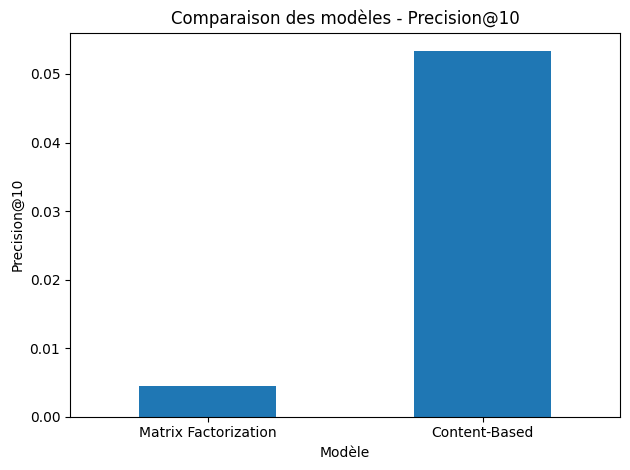

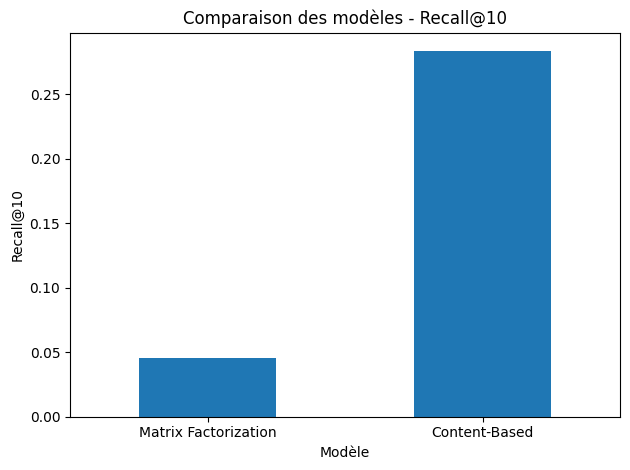

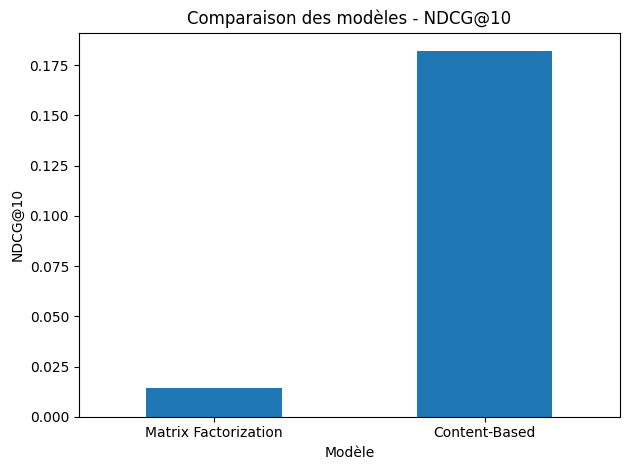

In [102]:
import matplotlib.pyplot as plt

# Un graphique par métrique (à partir de summary)
for metric in summary.columns:
    plt.figure()
    summary[metric].plot(kind="bar")
    plt.title(f"Comparaison des modèles - {metric}")
    plt.ylabel(metric)
    plt.xlabel("Modèle")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
